# First Practical Session on Registration

**Name** : *Vrushank Agrawal*

This first practical session will guide you into different registration methods you saw in the first 2 class.
First we will introduce the data and some plotting fun_columntions. 
In the first part of this labwork, we will implement the linear registration of two images of anchors that you saw in 
the first lecture. 
In the second part, we will implement non linear-registration as you saw it in the second lecture.

Recall that we consider $n$ landmarks $(x_i)_{1 \leq i \leq n}$ in the Image $I_{reca}$ that we want to match to the points $(y_i)_{1 \leq i \leq n}$ in the reference image $I_{ref}$ with an invertible transformation $\phi$.


The registration is defined by 
\begin{equation*}
\Phi(x_i) \approx y_i
\end{equation*}

for each $x_i$, point of $I_{reca}$.




In [ ]:
# Run this the first time you launch the kernel on Colab.
! git clone https://github.com/AgatheSenellart/DataMAA308.git
! mv DataMAA308/data data
! mv DataMAA308/Images Images 
# If you are running the notebook locally and this cell doesn't work
# download the data folder and Images folder from the url 
# https://github.com/AgatheSenellart/DataMAA308.git (Code/Download zip) 
# and place them in the same folder as your notebook.

fatal: destination path 'DataMAA308' already exists and is not an empty directory.
mv: cannot stat 'DataMAA308/data': No such file or directory
mv: cannot stat 'DataMAA308/Images': No such file or directory


In [ ]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib as mpl

mpl.rcParams['image.origin'] = 'upper'
%matplotlib inline

## 1. Plot functions and Data

### 1.1 Plot functions
The functions below are provided, and will be called in specific piece of code you will see later. You don't need to take care about it, except if you want to understand all the process of visualization of course.

In [ ]:
def plot_grid_def(n_row,n_column,vX,vY,axes=None):
    '''
    Returns a grid of the deformation field computed with displacements fields vX and vY. 
    ---
    n_row : number of rows in image
    n_column : number of columns in image
    vX, vY : displacement fields of n points in X and Y directions.
    '''
    xgrid,ygrid = np.meshgrid(np.arange(0,n_row,20),np.arange(0,n_column,20))


    XgD = xgrid + vX.reshape(xgrid.shape)
    YgD = ygrid + vY.reshape(ygrid.shape)
    
    if axes is None :
        plt.figure()
        for k in range(np.shape(XgD)[0]):
            plt.plot(XgD[k,:],YgD[k,:],'-k')

        for k in range(np.shape(XgD)[1]):
            plt.plot(XgD[:,k],YgD[:,k],'-k')
        plt.show()
    else:
        for k in range(np.shape(XgD)[0]):
            axes.plot(XgD[k,:],YgD[k,:],'-k')

        for k in range(np.shape(XgD)[1]):
            axes.plot(XgD[:,k],YgD[:,k],'-k')
            


### 1.2 Data importation and pre-processing

The guideline for this practical session and the next one on registration will be an_columnhors.

- $I_{ref}$ : the red an_columnhor, is the referen_columne ( or target) image 
-  $I_{reca}$  : the grey an_columnhor, is the picture to register 


Here landmarks are already provided, in .npy objects.


In [ ]:
# Load the images
Iref = mpimg.imread('./Images/image_redanch.jpg') 
Ireca = mpimg.imread('./Images/image_greyanch.jpg')

# Pad the reference image so that it has the same size as Ireca
Iref = np.concatenate((Iref,255*np.ones((45,300,3),dtype=np.int8)),axis=0)

# Pad both images with a lot of white pixels to avoid issues during registration.
n_row,n_column,_ = Ireca.shape
print(n_row, n_column)

pad = 255*np.ones((n_row,n_column,3),dtype=np.int8);
Iref = np.concatenate((np.concatenate([pad,pad,pad],axis=1),np.concatenate([pad,Iref,pad],axis=1),np.concatenate([pad,pad,pad],axis=1)),axis=0)
Ireca = np.concatenate((np.concatenate([pad,pad,pad],axis=1),np.concatenate([pad,Ireca,pad],axis=1),np.concatenate([pad,pad,pad],axis=1)),axis=0)

# Keep positions of "utils pixels"
row_util = np.arange(n_row,(2*n_row))
column_util = np.arange(n_column,(2*n_column))

297 300


Let's visualize the original images. 

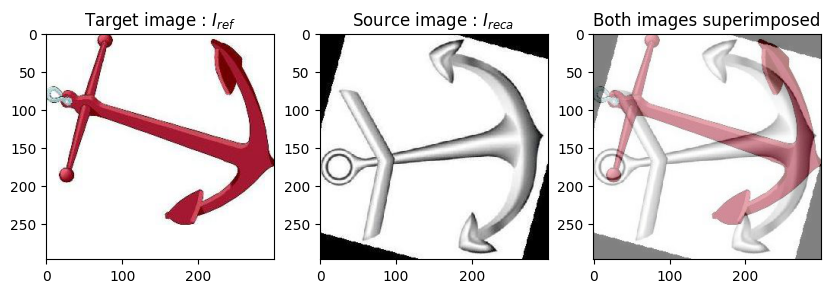

In [ ]:
# Display the images

plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(Iref[:,column_util,:][row_util]) # only display relevant pixels
plt.title(r'Target image : $I_{ref}$')
plt.subplot(1,3,2)
plt.imshow(Ireca[:,column_util,:][row_util])
plt.title(r'Source image : $I_{reca}$')
plt.subplot(1,3,3)
plt.imshow(Iref[:,column_util,:][row_util])
plt.imshow(Ireca[:,column_util,:][row_util],alpha=0.5)
plt.title('Both images superimposed')
plt.show()

### 1.3 Original images with landmarks

In this labwork, we aim to deform the source image $I_{reca}$ so to registrate it to the target image $I_{ref}$. 
In other words, we will construct a deformation $\phi$ and deform $I_{reca}$ to construct $I_{reca}(\phi^{-1})$.
We will construct the deformation $\phi$ so that $$\forall i, 1 \leq i \leq n, \phi(x_i) \approx y_i$$ where $(x_i)_{1 \leq i \leq n}$ are the landmarks in $I_{reca}$ and $(y_i)_{1 \leq i \leq n}$ are the landmarks in $I_{ref}$.

The landmarks for this labwork are provided in .npy files.
Below we load them and visualize them. 

In [ ]:
'''
Preca and Pref are sets of reference points for each picture : 
- Preca for the image to register (grey anchor) 
- Pref for the target image (red anchor).
We load them in numpy arrays.
Npts is the number of landmarks in each set (same number in Preca and Pref).
'''


Preca = np.load('./data/PsrcAnchors.npy') 
Pref = np.load('./data/PtarAnchors.npy') 
Npts = np.size(Preca,1)

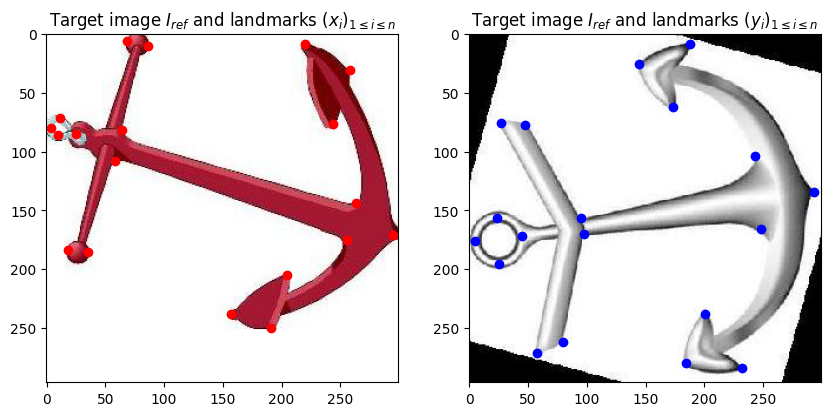

In [ ]:
# Visualize the landmarks on the images
plt.figure(1,figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(Iref[:,column_util,:][row_util])
plt.plot(Pref[0,:],Pref[1,:],'or')
plt.title(r'Target image $I_{ref}$ and landmarks $(x_i)_{1 \leq i \leq n}$')
plt.subplot(1,2,2)
plt.imshow(Ireca[:,column_util,:][row_util])
plt.plot(Preca[0,:],Preca[1,:],'ob')
plt.title(r'Target image $I_{ref}$ and landmarks $(y_i)_{1 \leq i \leq n}$')
plt.show()

## 2. Linear registrations

In this section, we consider a linear registration of the form :
\begin{equation}
\phi(x) = Ax + t
\end{equation}

### 2.1 Linear registration using triplets of points

**Instructions** :


In this first part, you have to implement the **linear registration using 3 landmarks**. Given three pairs of landmarks $(x_1,y_1),(x_2,y_2), (x_3,y_3)$ you have to compute the parameters $A,t$ such that $\phi(x_i) = y_i$ for $1 \leq i \leq 3$ as seen in the first lecture. 


You can choose a set of 3 landmarks by writing indexes in the vector `PtsInd`, associated with the points in `X1,X2, X3` for $I_{reca}$ and `Y1,Y2,Y3` for $I_{ref}$ of chosen indexes.

In [ ]:
######### 
# You can choose here a triplet of points, 
# by given integers corresponding to indexes in arrays of landmarks.
landmarks_idx = [0,1,2] # this is a possible choice
# PtsInd = list(range(6,9))# this is another possible choice

# Coordinates of triplet for source images
X1 = Preca[:,landmarks_idx[0]]; X2 = Preca[:,landmarks_idx[1]]; X3 = Preca[:,landmarks_idx[2]]

# Coordinates of triplet for target image
Y1 = Pref[:,landmarks_idx[0]]; Y2 = Pref[:,landmarks_idx[1]]; Y3 = Pref[:,landmarks_idx[2]]

print(f'X1 is a numpy array of shape {X1.shape}')
print(f'Y1 is a numpy array of shape {Y1.shape}')



X1 is a numpy array of shape (2,)
Y1 is a numpy array of shape (2,)


The next cell plots the source and target images superimposed with your three selected landmarks.


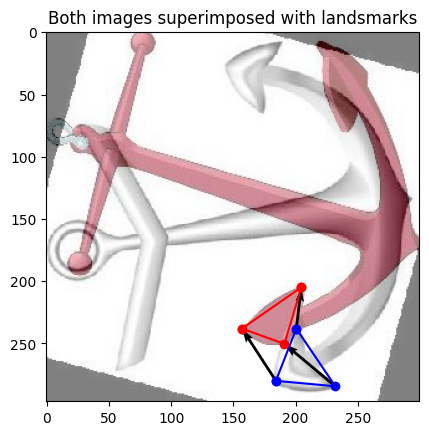

In [ ]:
plt.figure()
## Images
plt.imshow(Iref[:,column_util,:][row_util])
plt.imshow(Ireca[:,column_util,:][row_util],alpha=0.5)
#Landmarks
plt.plot(Preca[0,landmarks_idx],Preca[1,landmarks_idx],'-ob',[Preca[0,landmarks_idx[2]],Preca[0,landmarks_idx[0]]],[Preca[1,landmarks_idx[2]],Preca[1,landmarks_idx[0]]],'-ob');
plt.plot(Pref[0,landmarks_idx],Pref[1,landmarks_idx],'-or',[Pref[0,landmarks_idx[2]],Pref[0,landmarks_idx[0]]],[Pref[1,landmarks_idx[2]],Pref[1,landmarks_idx[0]]],'-or');
# Arrows between images
plt.quiver(Preca[0,landmarks_idx],Preca[1,landmarks_idx],Pref[0,landmarks_idx]-Preca[0,landmarks_idx],Pref[1,landmarks_idx]-Preca[1,landmarks_idx],scale=300,angles='xy');
plt.title('Both images superimposed with landsmarks')
plt.show()

#### 2.1.1 Estimation of the affine registration parameters

**Below, you have to compute the parameters of affine tranformation, A and t, as seen in first lecture, using the 3 landmarks defined above.**

In [ ]:
'''
TO DO : compute A affine transformation matrix 2x2, and t translation vector 2x1 with 3 correspoding points.
----
A : array 2 by 2 
t : vector of size 2 (or array 2 by 1) 

'''
# you can introduce intermediate variables
X_coords = np.column_stack((X1-X2, X2-X3))
Y_coords = np.column_stack((Y1-Y2, Y2-Y3))

# A = Y(X^-1)
A = Y_coords.dot(np.linalg.inv(X_coords))
t = np.array(1/3*(Y1+Y2+Y3)) - A.dot(np.array(1/3*(X1+X2+X3)))

'''
TO DO : Compute the registration of the source landmarks. It corresponds to their position in the source image after affine transformation and translation. 
---
Xreg1, Xreg2, Xreg3 : array (2 by 1) or vector (2,)
'''

Xreg1 = np.array(A.dot(X1) + t)
Xreg2 = np.array(A.dot(X2) + t)
Xreg3 = np.array(A.dot(X3) + t)

#### 2.1.2 The deformation field

Now that we have computed the parameters $A, t$ of our deformation $\phi(x) = Ax +t$, we will visualize the effet on the entire image domain of $I_{reca}$.

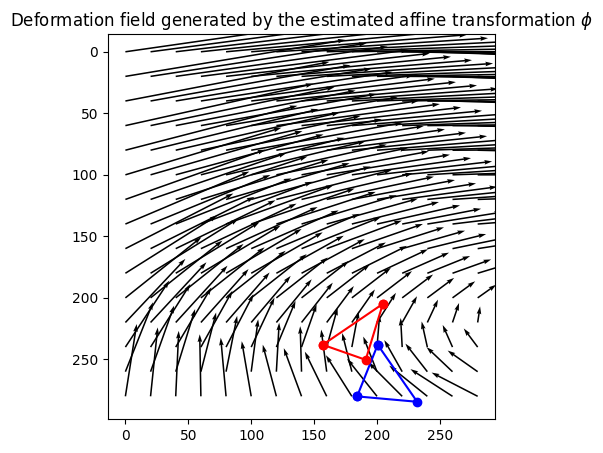

In [ ]:
### We construct a grid of points on the domain of Ireca
grid_x,grid_y = np.meshgrid(np.arange(0,n_column,20),np.arange(0,n_row,20))
grid_x = grid_x.reshape(1,-1) # The coordinates of the points on the first axis
grid_y = grid_y.reshape(1,-1) # The coordinates of the points on the second axis

grid = np.concatenate([grid_x,grid_y],axis=0) # array (2 by N)

'''
TO DO :

`grid` contains the coordinates of 20 points forming a regular 2D-grid.
The first row contains the first coordinates, the second row the second axis coordinates.

Compute the registration of this array with affine registration parameters A and t.

You obtain gridReg : array 2xN, with positions of grid points after affine transformation and translation following A and t.
'''

gridReg = A.dot(grid) + np.tile(t.reshape(-1, 1), (1, grid.shape[1]))

#################################
# Below is the code to visualize the deformation of the regular grid. 
# It gives you intuition of the displacement of source image points to reach their wanted positions in registered image. 

plt.figure(3,figsize=(5,5))
plt.plot(Preca[0,landmarks_idx],Preca[1,landmarks_idx],'-ob',[Preca[0,landmarks_idx[2]],Preca[0,landmarks_idx[0]]],[Preca[1,landmarks_idx[2]],Preca[1,landmarks_idx[0]]],'-ob');
plt.plot(Pref[0,landmarks_idx],Pref[1,landmarks_idx],'-or',[Pref[0,landmarks_idx[2]],Pref[0,landmarks_idx[0]]],[Pref[1,landmarks_idx[2]],Pref[1,landmarks_idx[0]]],'-or');
plt.quiver(grid_x,grid_y,gridReg[0,:] - grid_x, gridReg[1,:] - grid_y,angles='xy',scale=400)
plt.gca().invert_yaxis()
plt.title(r'Deformation field generated by the estimated affine transformation $\phi$')
plt.show()

#### 2.1.3 Registration of the source image with the computed parameters A and t.


Now that you have your parameters $A$ and $t$, you want to use them to compute the registration of your full source image $I_{reca}$(the grey anchor). 
During the lecture you saw that the action of the mapping on the image $I_{reca}$ is defined by $y \mapsto I_{reca}(\phi^{-1}(y))$.

By using $\phi^{-1}$ we can here compute the inverse transformation of a grid, given by $\phi^{-1}(grid)$. Then we match $\phi^{-1}(grid)$ and $I_{reca}$  points.

We can finally move each point of $I_{reca}$ to its registered position to match with the target image.

**Your task here is to compute the inverse transformation of the grid given by x and y coordinates in vectors im_x and im_y.**


In [ ]:
##################################################
# This code computes a grid the same size as Ireca.
# im_x : (1 by n_row*n_column) contains the first axis coordinates, valued from 0 to n_column.
# im_y : (1 by n_row*n_column) contains the second axis coordinates, values from 0 to n_row.
# These vectors are used to find the corresponding position of each pixel between the source image and the registered image.
im_x,im_y = np.meshgrid(np.arange(0,n_column),np.arange(0,n_row))
im_x = im_x.reshape(1,-1)
im_y = im_y.reshape(1,-1)

im_grid = np.concatenate([im_x,im_y],axis=0)
##################################################

**TO DO** : 

Compute the transformation of the points in `im_grid` by $\phi^{-1}$.

(2, 89100)
2405700


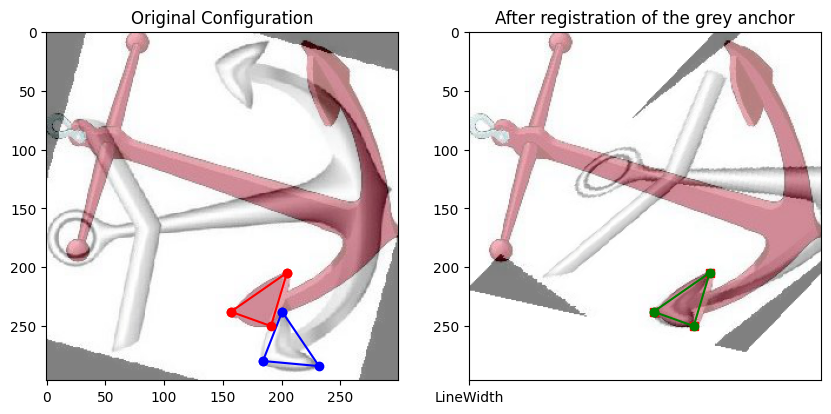

In [ ]:
'''
TO DO :
Compute the inverse transformation of im_grid.
----
gridRegInv : array 2 by N (=n_column*n_row)
'''

print(im_grid.shape)

A_inv = np.linalg.inv(A)
gridRegInv = A_inv.dot(im_grid - np.stack([t]*(im_grid.shape[1]), axis=-1))

##############################
# This code computes the registered image by finding the correspondence 
# between a source pixel and its position in the registered image.

# For each point of gridReg in the target image space :
# 1. find the corresponding pixel in the source image (position given by gridRegInv[:,i])
# 2. assign this source pixel value to the corresponding registered pixel.
# We obtain Jreg, the source image after affine registration, which should approximately match the target image.

Jreg = np.zeros((n_row,n_column,3)) # create empty image

print(Ireca.size)

for i in range(im_grid.shape[1]): # Fill the pixels values one by one
    value_source = Ireca[int(round(gridRegInv[1,i]) + n_row), int(round(gridRegInv[0,i]) + n_column)]
    Jreg[im_y[:,i],im_x[:,i],:] = value_source

Jreg = Jreg/255. # normalize the pixel values


##############################################################
# Below we plot the original configuration of our anchors, 
# and the final position after registration of the grey anchor.
##############################################################

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(Iref[:,column_util,:][row_util])
plt.imshow(Ireca[:,column_util,:][row_util],alpha=0.5)
plt.plot(Preca[0,landmarks_idx],Preca[1,landmarks_idx],'-ob',[Preca[0,landmarks_idx[2]],Preca[0,landmarks_idx[0]]],[Preca[1,landmarks_idx[2]],Preca[1,landmarks_idx[0]]],'-ob')
plt.plot(Pref[0,landmarks_idx],Pref[1,landmarks_idx],'-or',[Pref[0,landmarks_idx[2]],Pref[0,landmarks_idx[0]]],[Pref[1,landmarks_idx[2]],Pref[1,landmarks_idx[0]]],'-or')
plt.title('Original Configuration')

plt.subplot(1,2,2)
plt.imshow(Iref[:,column_util,:][row_util])
plt.imshow(Jreg,alpha=0.5)
plt.plot(Pref[0,landmarks_idx],Pref[1,landmarks_idx],'sr','LineWidth',2)
plt.plot([Xreg1[0],Xreg2[0],Xreg3[0],Xreg1[0]],[Xreg1[1],Xreg2[1],Xreg3[1],Xreg1[1]],'-og','LineWidth',2)
plt.title('After registration of the grey anchor')
plt.show()

### 2.2 Registration driven by  n landmarks

Now you have to **compute registration with the full set of landmarks in each image.**
It corresponds to the part 2.2.2 in the lecture notes.

We have $N$ pairs of landmarks $(x_i, y_i)_{1 \leq i \leq N}$ and we want to compute the linear registration parameters $A,t$ that minimizes the energy $$E(\phi) = \sum_i || \phi(x_i) -y_i||^2 \,.$$ 


The set of source landmarks $(x_i)_{1 \leq i \leq N}$ is given by array `Preca` and
the set of target landmarks $(y_i)_{1 \leq i \leq N}$ is given by array `Pref` that we loaded at the beginning of the labwork.

In [ ]:
# Check the size of Preca, Pref
print(Preca.shape, Pref.shape)

(2, 19) (2, 19)


#### 2.2.1 Estimation of the affine registration parameters

**TODO** : Compute the matrix $A$ and the translation vector $t$ according to the formulas you saw in the lecture for the n-points registration. 

In [ ]:
'''
TO DO : compute A the affine transformation matrix 2x2, and t the translation vector 2x1 
----
A : array 2 by 2 
t : vector of size 2 (or array 2 by 1)  
'''

n_landmarks = Preca.shape[1]
Preca_mean = np.mean(Preca, axis=1)
Pref_mean = np.mean(Pref, axis=1)

Preca_bar = Preca - np.stack([Preca_mean]*n_landmarks, axis=-1)
Pref_bar = Pref - np.stack([Pref_mean]*n_landmarks, axis=-1)

A = (Pref_bar.dot(Preca_bar.T)).dot(np.linalg.inv(Preca_bar.dot(Preca_bar.T)))
t = Pref_mean - A.dot(Preca_mean)

'''
TO DO :
Compute the registration of the source landmarks Preca.
It corresponds to their position in the source image after affine transformation and translation. 
----
Preg : array 2 by n_landmarks
''' 

Preg = A.dot(Preca) + np.stack([t]*n_landmarks, axis=-1)

#### 2.2.2 The deformation field

We visualize the deformation field induced by the affine transformation you just computed. 

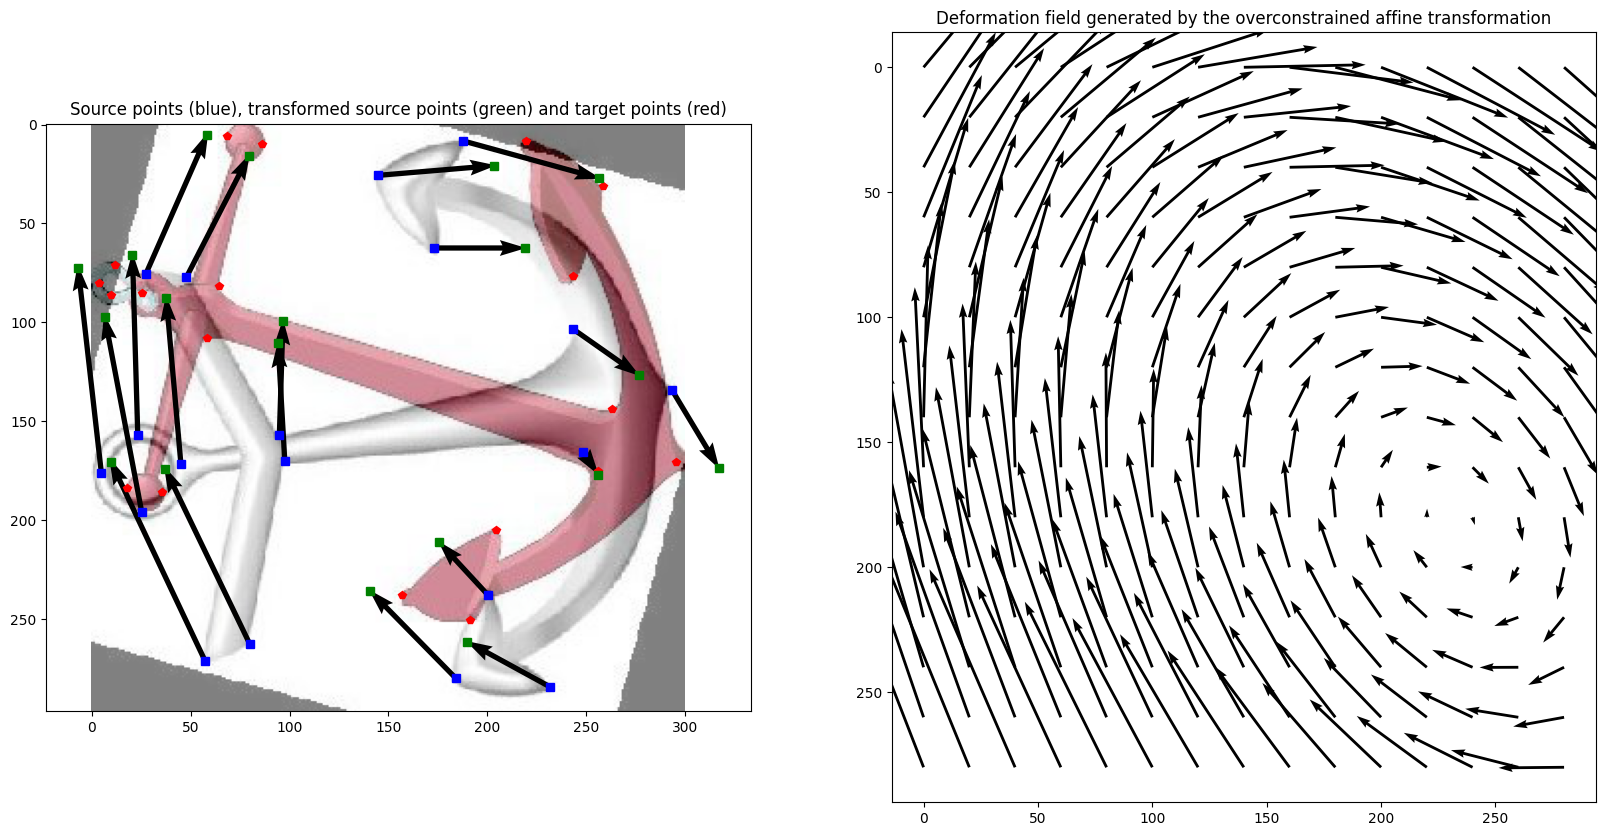

In [ ]:
### A regular grid of points to register
grid_x,grid_y = np.meshgrid(np.arange(0,n_column,20),np.arange(0,n_row,20));
grid_x = grid_x.reshape(1,-1)
grid_y = grid_y.reshape(1,-1)

grid = np.concatenate([grid_x,grid_y],axis=0) # array (2 by N)

'''
TO DO : 
`grid` contains the coordinates of 20 points forming a regular 2D-grid.
The first row contains the first coordinates, the second row the second axis coordinates.

Compute the registration of this array with affine registration parameters A and t.

You obtain gridReg : array 2xN, with positions of grid points after affine transformation and translation following A and t.
'''

gridReg = A.dot(grid) + np.tile(t.reshape(-1, 1), (1, grid.shape[1]))

###########################
# Below is the code to visualize the deformation of the regular grid. 
# It gives you intuition of the displacement of source image points to reach their wanted positions in registered image. 
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(Iref[:,column_util,:][row_util])
plt.imshow(Ireca[:,column_util,:][row_util],alpha=0.5)
plt.plot(Preca[0,:],Preca[1,:],'sb')
plt.plot(Pref[0,:],Pref[1,:],'pr')
plt.plot(Preg[0,:],Preg[1,:],'sg')
plt.quiver(Preca[0,:],Preca[1,:],Preg[0,:]-Preca[0,:],Preg[1,:]-Preca[1,:],scale=350,angles='xy')
plt.title('Source points (blue), transformed source points (green) and target points (red)')

plt.subplot(1,2,2)
plt.quiver(grid_x,grid_y,gridReg[0,:] - grid_x, gridReg[1,:] - grid_y,angles='xy',scale=400)
plt.title('Deformation field generated by the overconstrained affine transformation')
plt.gca().invert_yaxis()
plt.show()


#### 2.2.3 Registration of the source image with the computed parameters A and t.

These are the same formulas and the same process as in part 2.1.3 with the 3 landmarks.


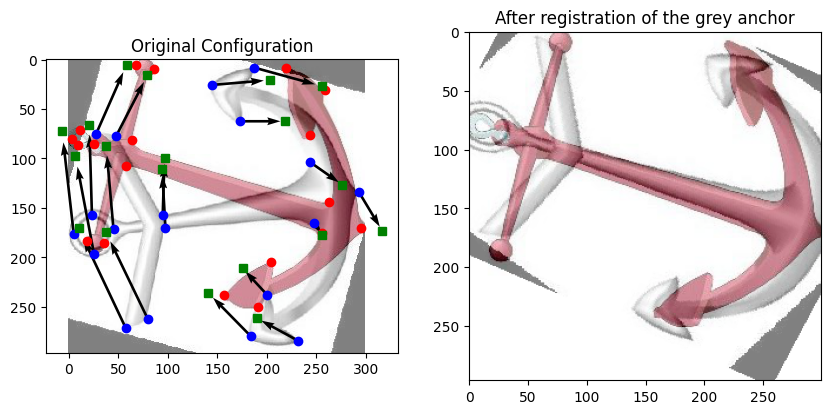

In [ ]:
##################################################
# This code computes a grid given by two vectors:
# xim : 1 by n_row*nc (x coordinates)
# yim : 1 by n_row*nc (y coordinates)
# These vectors are used to find the corresponding position of each pixel between the source image and the registered image.
im_x,im_y = np.meshgrid(np.arange(0,n_column),np.arange(0,n_row));
im_x = im_x.reshape(1,-1)
im_y = im_y.reshape(1,-1)

im_grid = np.concatenate([im_x,im_y],axis=0)

'''
TO DO :
Compute the inverse transformation of a grid given by xim and yim.
----
gridRegInv : array 2 by N (=nc*n_row)
'''
A_inv = np.linalg.inv(A)
gridRegInv = A_inv.dot(im_grid - np.stack([t]*(im_grid.shape[1]), axis=-1))

##############################
# This code computes the registered image by finding the correspondence 
# between a source pixel and its position in the registered image.
# For each pixel i in im_grid in the target image space:
# 1. find the corresponding pixel in the source image (position given by gridRegInv[:,i])
# 2. assign this source pixel value to the corresponding registered pixel in Jreg (the registered image).
# We obtain Jreg, the registered image.
Jreg = np.zeros((n_row,n_column,3))
for i in range(im_x.shape[1]):
    value = Ireca[int(round(gridRegInv[1,i]) + n_row), int(round(gridRegInv[0,i]) + n_column),:]
    Jreg[im_y[:,i],im_x[:,i],:] = value

Jreg = Jreg/255.  # array (n_row*nc*3)

#######################
# Below we plot the original configuration of our anchors, 
# and the final position after registration of the grey anchor.
######################

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(Iref[:,column_util,:][row_util])
plt.imshow(Ireca[:,column_util,:][row_util],alpha=0.5)
plt.plot(Preca[0,:],Preca[1,:],'ob')
plt.plot(Pref[0,:],Pref[1,:],'or')
plt.plot(Preg[0,:],Preg[1,:],'sg')
plt.quiver(Preca[0,:],Preca[1,:],Preg[0,:]-Preca[0,:],Preg[1,:]-Preca[1,:],scale=400,angles='xy')
plt.title('Original Configuration')

plt.subplot(1,2,2)
plt.imshow(Iref[:,column_util,:][row_util])
plt.imshow(Jreg,alpha=0.5)
plt.title('After registration of the grey anchor')
plt.show()

**Q: How is the registered image now ?** 
**What are the limitations of this method ?**

A. The registered image is well-aligned with the source image now. This was possible only because we included more points that were relatively well distributed in the image and that is also the limitation of this method.

## 3. Non-linear registration with small deformations

### 3.1 Preprocessing

#### 3.1.2 New landmarks
We load a new set of landmarks for both images.

In [ ]:
Preca3 = np.load('./data/PsrcAnchors3.npy')
Pref3 = np.load('./data/PtarAnchors3.npy') 
n_landmarks = Preca3.shape[1]
print('We have now '+str(n_landmarks)+' landmarks.')

We have now 26 landmarks.


#### 3.1.2 Affine registration step

Before we implement local small transformations, we apply the overconstrained affine registration studied in the previous section, **with the already computed parameters A and t** from 1.3.2.

This corresponds to a preprocessing step, which gives us "intermediate" image and landmarks: a grey anchor registered with the affine transformation and corresponding registered landmarks.
Then we will compute the local deformation on this "intermediate" image. 

**Instructions** :

**Compute below the affine registration of the new landmarks Preca3**. 
The image $I_{reca}$ is still the same as in previous parts, so you already have the affine registered image in the array `Jreg`.

**In the remainder of this section, you will only consider `Preca3` (the landmarks after this first affine transformation) and `Jreg` (no more Preca and Ireca).**


In [ ]:
# Affine transformation of new landmarks with precedent parameters A and b.

'''
TO DO : Compute the registration of the source landmarks Preca3 with already estimated parameters A and t from previous part. 
It corresponds to their position after affine transformation and translation. 
---
Preg3 : array 2 by n_landmarks
'''
Preg3 = A.dot(Preca3) + np.stack([t]*n_landmarks, axis=-1)

######################
# Registered image Jreg from previous section with padding, you don't have to touch it.
JregA = np.concatenate((np.concatenate([pad,pad,pad],axis=1),np.concatenate([pad,255.*Jreg,pad],axis=1),np.concatenate([pad,pad,pad],axis=1)),axis=0)/255


Below you can select the landmarks that you are going to use for the registration. You can choose a set of 3 landmarks as in the first part, or you can decide to consider all the landmarks from Preg3. 
The code thereafter display your selection of landmarks and their positions after overconstrained affine registration.

In [ ]:
######### 
# You can choose here a triplet of points, 
# by given integers corresponding to indexes in arrays of landmarks.
# PtsInd = [5,12,25] # selects the index of the landmark here
# Npts = len(PtsInd)

##### Or you can select all landmarks
PtsInd = np.arange(0,n_landmarks)
Npts = len(PtsInd)
# Comment the part of the code that you don't want to use above

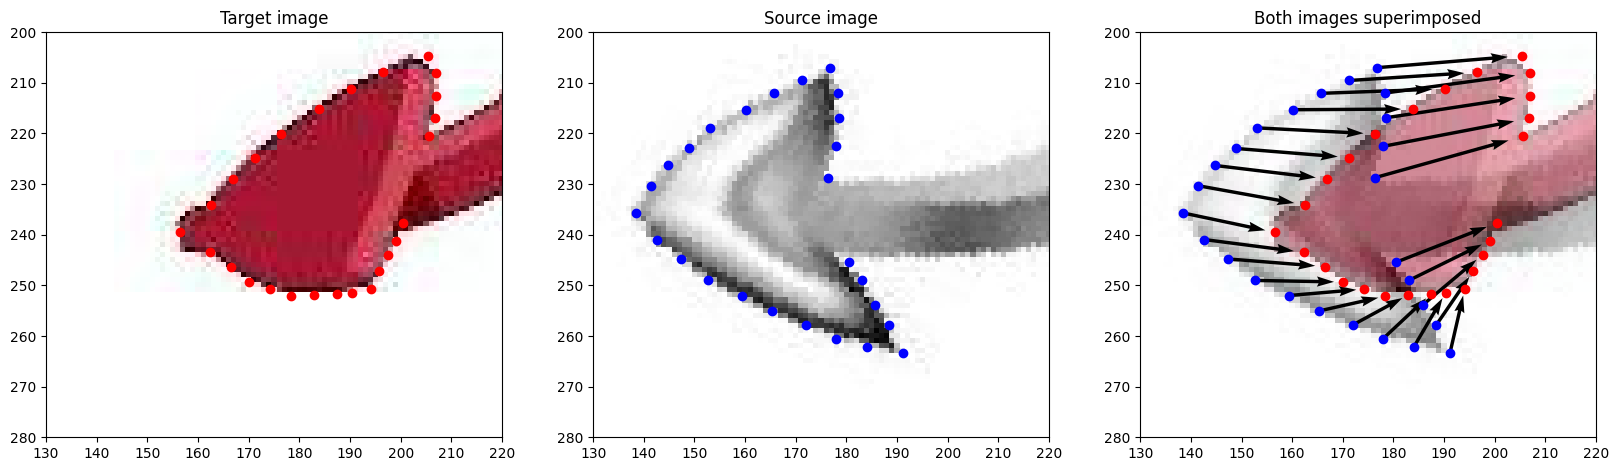

In [ ]:
# Visualize images and new landmarks
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)

# Target Image and landmarks
plt.imshow(Iref[:,column_util,:][row_util]);
plt.plot(Pref3[0,PtsInd],Pref3[1,PtsInd],'or')
plt.title('Target image')
plt.axis([130,220,280,200])

# Source Image and landmarks (after first affine registration) 
plt.subplot(1,3,2)
plt.plot(Preg3[0,PtsInd],Preg3[1,PtsInd],'ob')
plt.imshow(Jreg,origin='upper')
plt.axis([130,220,280,200])
plt.title('Source image')

# Superimposition of both images
plt.subplot(1,3,3)
plt.imshow(Iref[:,column_util,:][row_util])
plt.imshow(Jreg,alpha=0.5)
plt.plot(Preg3[0,PtsInd],Preg3[1,PtsInd],'ob')
plt.plot(Pref3[0,PtsInd],Pref3[1,PtsInd],'or')
plt.quiver(Preg3[0,PtsInd],Preg3[1,PtsInd],Pref3[0,PtsInd]-Preg3[0,PtsInd],Pref3[1,PtsInd]-Preg3[1,PtsInd],scale=100,angles='xy')
plt.axis([130,220,280,200])
plt.title('Both images superimposed')

plt.show()

Above you have a focus on the overconstrained affine registration results. We can clearly see here that transformations affected the whole image, but shapes are still not matching. Now, you will implement kernel methods to register more precisely anchor images.

### 3.2 Computation of non linear registration - small deformations

#### 3.2.1 Computing the parameters and registration

Recall that in the second lecture we defined a deformation $\phi(x) = x + v(x)$ where the displacement of the point $x$ is :

$$ v(x) = \sum_{1 \leq i \leq n} \mathcal K(x,x_i) \alpha_i $$

The $(x_i)_{1 \leq i \leq n}$ are the landmarks in the source image and the $(\alpha_i)_{1 \leq i \leq n}$ are the momentas of the landmarks. They parameterize the entire deformation. 

In this lab session $\mathcal K$ is a gaussian kernel such that $\mathcal K(x,y) = \exp(-\frac{||x-y||^2}{2\sigma^2})$. 

We aim at finding the best parameters $(\alpha_i)_{1 \leq i \leq n}$ so as to minimize (as seen in the lecture):

$$ E(\alpha) = || X + K\alpha - Y||^2 - \gamma\alpha^T K \alpha $$

with the notations :

- $\gamma$ is a regularizing parameter
- $\alpha$ is the vertical concatenation of the $(\alpha_i)_{1 \leq i \leq n}$. It is of shape (2xn,1) in the 2D case.
- X is the vertical concatenation of the $(x_i)_{1 \leq i \leq n}$. It is of shape (2xn,1) in the 2D case.
- Y is the vertical concatenation of the $(y_i)_{1 \leq i \leq n}$. It is of shape (2xn,1) in the 2D case.
-  K is a block matrix of size (2n,2n)  such that :
    $$ K =\left[\begin{array}{cccc} K(x_1,x_1).I_2  & K(x_1,x_2).I_2 & \dots & K(x_1,x_n).I_2\\ K(x_2,x_1).I_2  & K(x_2,x_2).I_2 & \dots & K(x_2,x_n).I_2\\ . &.&.&.\\K(x_n,x_1).I_2  & K(x_n,x_2).I_2 & \dots & K(x_n,x_n).I_2\\ \end{array} \right]$$




You can find below the parameters of the gaussian kernel. You can change these values after having computed everything to see the effect on the results.
Keep these variable's names in your code.

In [ ]:
## To PLAY WITH
gam =  0.8 # 0.000001 # 0.00001 # 0.0001
sigma = 5

**Instructions**:


Compute `K` the gaussian kernel of the global deformation of your selected landmarks. \
Then compute the momenta `alpha`. You will need these estimated to compute all your next displacement vectors.  \
You also compute `v_landmarks`, the displacement of your landmarks along vector v(landmark).
You must use `gam`and `sigma` defined above. 

To compute the matrix `K`, you might use `np.kron` (https://numpy.org/doc/stable/reference/generated/numpy.kron.html).

In [ ]:
'''
TO DO:
Compute K, alpha, v_landmarks. 
Eventually reshape the results to obtain the following output shapes :
----
K : array (2Npts, 2Npts) (Npts is the number of landmarks you consider)
alpha : array (2Npts,1)
v_landmarks : array (2,Npts) (Be careful when reshaping : we want the first column to contain the displacements 
    of the first landmark!)
'''
# version 1

# Compute the kernel
def kernel(x, y):
    return np.exp(-(np.linalg.norm(x-y)**2)/2*(sigma**2))

Kt = np.array([[kernel(Preg3[:,i], Preg3[:,j]) for j in range(Npts)] for i in range(Npts)])
K = np.kron(Kt, np.eye(2))
print('K is of shape',K.shape)

# Estimation 

alpha = np.linalg.inv(Kt + (gam * np.eye(Npts))).dot((Pref3-Preg3).T).reshape(2*Npts, 1)
print('alpha is of shape ', alpha.shape)

v_landmarks = K.dot(alpha).reshape(2, Npts)

print('v_landmarks is of shape ', v_landmarks.shape)


K is of shape (52, 52)
alpha is of shape  (52, 1)
v_landmarks is of shape  (2, 26)


**Instructions:**


Compute below the deformation kernel `Kr` of a grid defined by `im_x` and `im_y`, which has the same size than the source image. \
Then code the displacement vector `v_im` of this grid. \
Finally find the original position (in the source image) of registered points by inverse transformation of this grid (Section 3.1.2 of lectures).

In [ ]:
##################################################
# This code computes a grid given by two vectors:
# im_x : n_row*nc by 1 (x coordinates)
# im_y : n_row*nc by 1 (y coordinates)
# These vectors are used to find the corresponding position of each pixel between the source image and the registered image.
im_x,im_y = np.meshgrid(np.arange(0,n_column),np.arange(0,n_row))
im_x = im_x.reshape(-1,1)
im_y = im_y.reshape(-1,1)

'''
TO DO :

Compute the kernel Kr, and by following the displacement vectors v_grid of the grid points (using alpha computed above).
Then compute the inverse transformation of the grid points (im_x,im_y) in RegInvX, RegInvY.
-----
Kr : array  2*n_row*nc x 2*Npts
v_im : array  2 x n_row*nc
RegInvX : array n_row*nc x 1
RegInvY : array n_row*nc x 1

'''
im_grid = np.concatenate([im_x,im_y],axis=0)

Kr = np.array([[kernel(im_grid[i], Preg3[:,j]) for j in range(Npts)] for i in range(n_row*n_column)])
Kr = np.kron(Kr, np.eye(2))
print('Kr is of shape ', Kr.shape)

v_im = Kr.dot(alpha)
print('v_grid is of shape ', v_im.shape)

Kr is of shape  (178200, 52)
v_grid is of shape  (178200, 1)


In [ ]:
# estimating the inverse
RegInvX = im_x - v_im[:,0].reshape(-1,1)
RegInvY = im_y - v_im[:,1].reshape(-1,1)
print('RegInvX is of shape ', RegInvX.shape)

# ##############################
# # This code computes the registered image by finding the correspondence 
# # between a source pixel and its position in the registered image.
# # For each pixel i of gridReg in the target image space :
# # 1. find the corresponding pixel in the source image JregA (position given by RegInvX[i] and RegInvY)
# # 2. assign this source pixel value to the corresponding registered pixel in Jreg (the registered image).
# # We obtain JregNL, the registered image.

JregNL = np.zeros((n_row,n_column,3))
for i in range(im_x.shape[0]):
    value = JregA[int(round(RegInvY[i,0]) + n_row), int(round(RegInvX[i,0]) + n_column),:]
    JregNL[im_y[i],im_x[i],:] = value

RegInvX is of shape  (89100, 1)


#### 3.2.2 The displacement field (optional)

If you want to observe the displacement field of a regular grid you can compute here the kernel of a regular grid, and the associated displacement of points with `v_grid`. \
Then to use the computed field, you can uncomment the corresponding line in plot code in the next cell.

In [ ]:
# A grid with coordinates of pixels in a source image
grid_x,grid_y = np.meshgrid(np.arange(130,220,5),np.arange(200,280,5))
grid_x = grid_x.reshape(-1,1)
grid_y = grid_y.reshape(-1,1)

'''
TO DO:
Compute the kernel values Kgrid of the grid above and the associated displacement vectors.
-----
Kgrid: array 2*len(grid_x) x 2*Npts (Npts is the number of landmarks you consider)
v_grid: array 2 x len(grid_x)
''' 
xy_grid = np.concatenate([im_x,im_y],axis=0)

Kgrid = np.array([[kernel(xy_grid[i], Preg3[:,j]) for j in range(Npts)] for i in range(len(xy_grid))])
print('Kgrid is of shape ', Kgrid.shape)

v_grid = Kgrid.dot(alpha)
print('v_grid is of shape ', v_grid.shape)

Kgrid is of shape  (178200, 26)
v_grid is of shape  (178200, 2)


#### 3.2.3 Plots

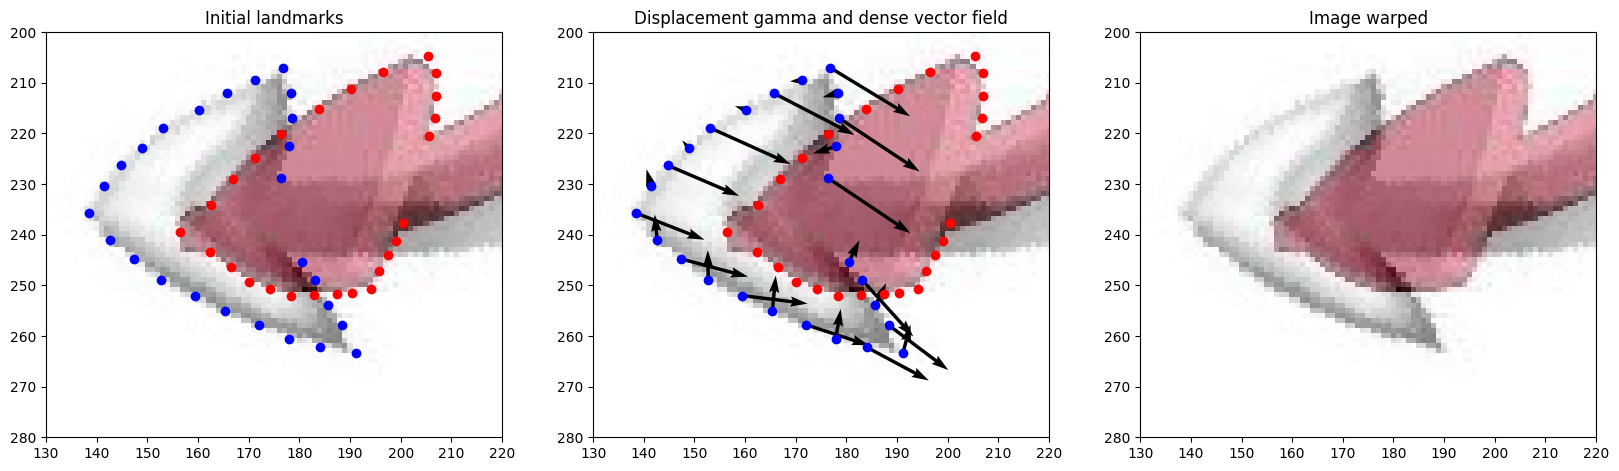

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
plt.imshow(Iref[:,column_util,:][row_util]);
plt.imshow(JregA[:,column_util,:][row_util],alpha=0.5)
plt.plot(Pref3[0,PtsInd],Pref3[1,PtsInd],'or')
plt.plot(Preg3[0,PtsInd],Preg3[1,PtsInd],'ob')
plt.title('Initial landmarks');
plt.axis([130,220,280,200])


plt.subplot(1,3,2)
plt.imshow(Iref[:,column_util,:][row_util])
plt.imshow(JregA[:,column_util,:][row_util],alpha=0.5)
plt.plot(Pref3[0,PtsInd],Pref3[1,PtsInd],'or')
plt.plot(Preg3[0,PtsInd],Preg3[1,PtsInd],'ob')
plt.quiver(Preg3[0,PtsInd],Preg3[1,PtsInd],v_landmarks[0],v_landmarks[1],scale=90,angles='xy')
######## HERE
# plt.quiver(grid_x,grid_y, v_grid[0], v_grid[1],angles='xy',scale=100) # line to uncomment if you want an overall displacement field, after coding it in the previous cell.
###############
plt.axis([130,220,280,200])
plt.title('Displacement gamma and dense vector field')

plt.subplot(1,3,3)
plt.imshow(Iref[:,column_util,:][row_util])
plt.imshow(JregNL,alpha=0.5)
plt.axis([130,220,280,200])

plt.title('Image warped')

plt.show()

**Play with parameters and the set of landmarks**. 

**Q: How `gam` and `sigma` affect the method ? Try to find the best values for the registrations of those two images.**

###  3.3 Whole image - full set of landmarks

In this new part we still consider small deformations but this time on the complete image.  
In order to do this we load a new set of landmarks for both source and target images.

In [ ]:
# Load a new set of landmarks for both images.

Preca2 = np.load('./data/PsrcAnchors2.npy') 
Pref2 = np.load('./data/PtarAnchors2.npy')
n_landmarks = Preca2.shape[1]
print('We have now '+str(n_landmarks)+' landmarks.')

We have now 129 landmarks.


Those new landmarks cover the entire image to avoid pathological registrations. 

#### 3.3.1 Affine registration step

Again we first register according to the overconstrained affine transformation found in the linear registration section with parameters `A` and `t`. Then we will see compute the local deformation on this "intermediate" image. 

In order to do it, you should **compute below the affine registration of new landmarks Preca2 and Pref2, with the estimated parameters A and t from part 1.3.2**. For the intermediate image, if you named previously the registered image  `Jreg`, you should retrieve and use it without problem.

In [ ]:
# Affine transformation of new landmarks with previous parameters A and b.

'''
TO DO : Compute the registration of the source landmarks Preca2 with aleady estimated parametrs A and t from previous part. 
It corresponds to their position after affine transformation and translation. 
---
Preg2 : array 2 by n_landmarks
'''

Preg2 = A.dot(Preca2) + np.stack([t]*n_landmarks, axis=-1)

### Affine transformation of the source image from previous section with padding, you don't have to touch it.
JregA = np.concatenate((np.concatenate([pad,pad,pad],axis=1),np.concatenate([pad,255.*Jreg,pad],axis=1),np.concatenate([pad,pad,pad],axis=1)),axis=0)/255

PregA = Preg2.copy() 
PrefA = Pref2.copy() 

## Optional : 
# After you've finished the lab, if you you want to see what happens when the first affine registration step is
# not well done, you can change `Preg2` by `Preg`and `Pref2` by `Pref` in two lines above. 

Our control points (landmarks) will be the full set of landmarks.

In [ ]:
PtsInd = np.arange(0,PrefA.shape[1])
Npts = PrefA.shape[1]
print(f'There are {Npts} landmarks.')

There are 129 landmarks.


You can visualize below the new landmarks, and the affine registration of these landmarks.

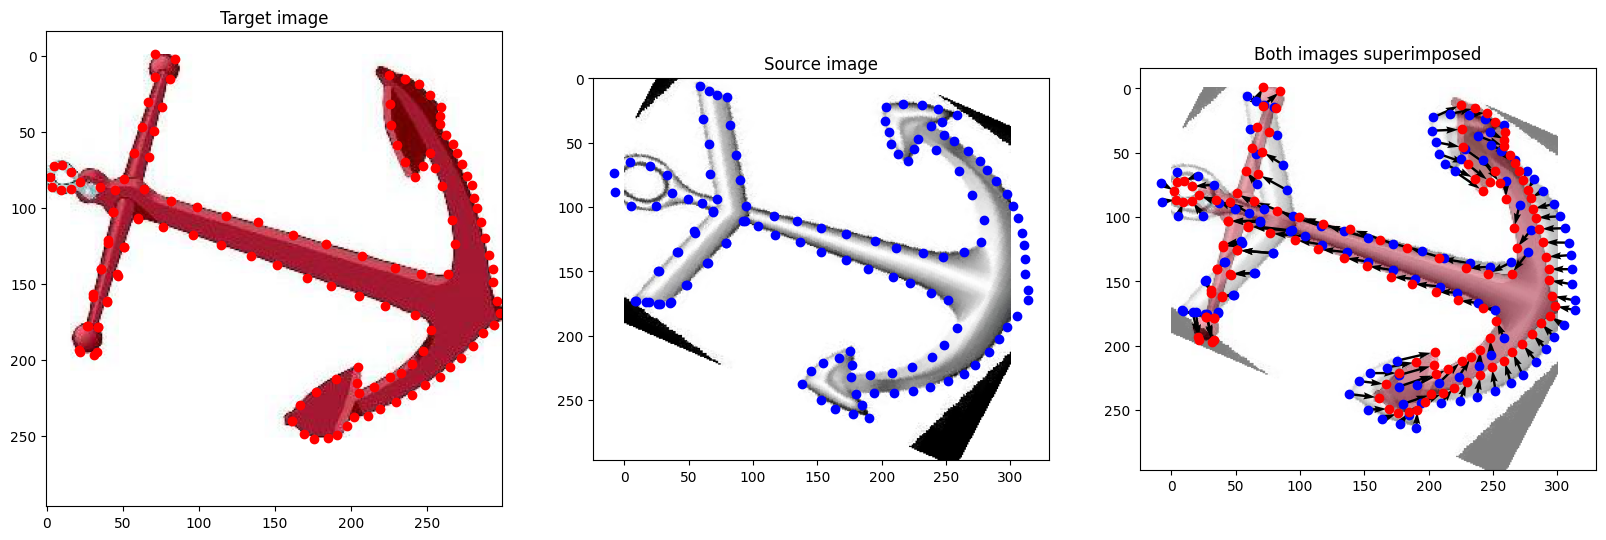

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(Iref[:,column_util,:][row_util]);
plt.plot(PrefA[0,PtsInd],PrefA[1,PtsInd],'or')
plt.title('Target image')

plt.subplot(1,3,2)
plt.imshow(Jreg)
plt.plot(PregA[0,PtsInd],PregA[1,PtsInd],'ob')
plt.title('Source image')

plt.subplot(1,3,3)
plt.imshow(Iref[:,column_util,:][row_util])
plt.imshow(Jreg,alpha=0.5)
plt.plot(PregA[0,PtsInd],PregA[1,PtsInd],'ob')
plt.plot(PrefA[0,PtsInd],PrefA[1,PtsInd],'or')
plt.quiver(PregA[0,PtsInd],PregA[1,PtsInd],PrefA[0,PtsInd]-PregA[0,PtsInd],PrefA[1,PtsInd]-PregA[1,PtsInd],scale=400,angles='xy')

plt.title('Both images superimposed')

plt.show()


#### 3.3.2 Computation of non linear registration - small deformations

As in 3.2 we compute a gaussian kernel `K`, and the momentas `alpha` for the non linear deformation.
You can find below the parameters of the gaussian kernel. You can change these values after having computed everything.
Keep these variable's names in your code.

In [ ]:
## To PLAY WITH
gam = 1 #0.001 #0.5
sigma = 30

**Instructions:**

Compute K the gaussian kernel of the global deformation of your selected landmarks. \
Then compute the momenta alpha. You will need these estimated to compute all your next displacement vectors.  \
You also compute v_landmarks the displacement of your landmarks.


In [ ]:
'''
TO DO:
Compute K, alpha, v_landmarks. 
Eventually reshape the results to obtain the following output shapes :
----
K : array (2Npts, 2Npts) (Npts is the number of landmarks you consider)
alpha : array (2Npts,1)
v_landmarks : array (2,Npts) (Be careful when reshaping : we want the first column to contain the displacements 
    of the first landmark!)

'''

# version 1

# Compute the kernel

Kt = np.array([[kernel(Preg2[:,i], Preg2[:,j]) for j in range(Npts)] for i in range(Npts)])
K = np.kron(Kt, np.eye(2))
print('K is of shape',K.shape)

# Estimation 

alpha = np.linalg.inv(Kt + (gam * np.eye(Npts))).dot((Pref2-Preg2).T).reshape(2*Npts, 1)
print('alpha is of shape ', alpha.shape)

v_landmarks = K.dot(alpha).reshape(2, Npts)

print('v_landmarks is of shape ', v_landmarks.shape)


K is of shape (258, 258)
alpha is of shape  (2, 129)
v_landmarks is of shape  (2, 129)


**Instructions:**

Compute below the deformation kernel `Kr` of a grid defined by im_x and im_y, which has the same size than the source image. \
Then code the displacement vectors v_grid of this grid. \
Finally find the original position (in the source image) of registered points by inverse transformation of this grid (Section 3.1.2 of lectures).

In [ ]:
##################################################
# This code computes a grid given by two vectors:
# im_x : n_row*nc by 1 (x coordinates)
# im_y : n_row*nc by 1 (y coordinates)
# These vectors are used to find the corresponding position of each pixel between the source image and the registered image.
im_x,im_y = np.meshgrid(np.arange(0,n_column),np.arange(0,n_row))
im_x = im_x.reshape(-1,1)
im_y = im_y.reshape(-1,1)



'''
TO DO :

Compute the kernel Kr, and by following the displacement vectors v_grid of the grid points (using alpha computed above).
Then compute the inverse transformation of the grid points (im_x,im_y) in RegInvX, RegInvY.
-----
Kr : array  2*n_row*nc x 2*Npts
v_im : array  2 x n_row*nc
RegInvX : array n_row*nc x 1
RegInvY : array n_row*nc x 1

'''

im_grid = np.concatenate([im_x,im_y],axis=0)

Kr = np.array([[kernel(im_grid[i], Preg3[:,j]) for j in range(Npts)] for i in range(n_row*n_column)])
Kr = np.kron(Kr, np.eye(2))
print('Kr is of shape ', Kr.shape)

v_im = Kr.dot(alpha)
print('v_grid is of shape ', v_im.shape)

RegInvX = im_x - v_im[0].reshape(-1,1)
RegInvY = im_y - v_im[1].reshape(-1,1)

print('RegInvX is of shape ', RegInvX.shape)

# ##############################
# # This code computes the registered image by finding the correspondence 
# # between a source pixel and its position in the registered image.
# # For each pixel i of gridReg in the target image space :
# # 1. find the corresponding pixel in the source image JregA (position given by RegInvX[i] and RegInvY)
# # 2. assign this source pixel value to the corresponding registered pixel in Jreg (the registered image).
# # We obtain JregNL, the registered image.

JregNL = np.zeros((n_row,n_column,3))
for i in range(im_x.shape[0]):
    value = JregA[int(round(RegInvY[i,0]) + n_row), int(round(RegInvX[i,0]) + n_column),:]
    JregNL[im_y[i],im_x[i],:] = value

    

Kr is of shape  (178200, 258)
v_grid is of shape  (2, 89100)
RegInvX is of shape  (89100, 1)


#### The displacement field (optional)


If you want to observe the displacement field of a regular grid you can compute here the kernel of a regular grid, and the associated displacement of points with `v_grid`. \
Then to use the computed field, you can uncomment the corresponding line in plot code in the next cell.

In [ ]:
# A grid with coordinates of pixels in a source image

grid_x,grid_y = np.meshgrid(np.arange(0,n_column,20),np.arange(0,n_row,20))
grid_x = grid_x.reshape(-1,1)
grid_y = grid_y.reshape(-1,1)


'''
TO DO:
Compute the kernel values Kgrid of the grid above and the associated displacement vectors.
-----
Kgrid: array 2*len(grid_x) x 2*Npts (Npts is the number of landmarks you consider)
v_grid: array 2 x len(grid_x)
''' 

grid_xy = np.concatenate([im_x,im_y],axis=0)

Kgrid = np.array([[kernel(grid_xy[i], Preg3[:,j]) for j in range(Npts)] for i in range(len(grid_xy))])
print('Kgrid is of shape ', Kgrid.shape)

v_grid = Kgrid.dot(alpha)
print('v_grid is of shape ', v_grid.shape)

Kgrid is of shape  (450, 258)
v_grid is of shape  (2, 225)


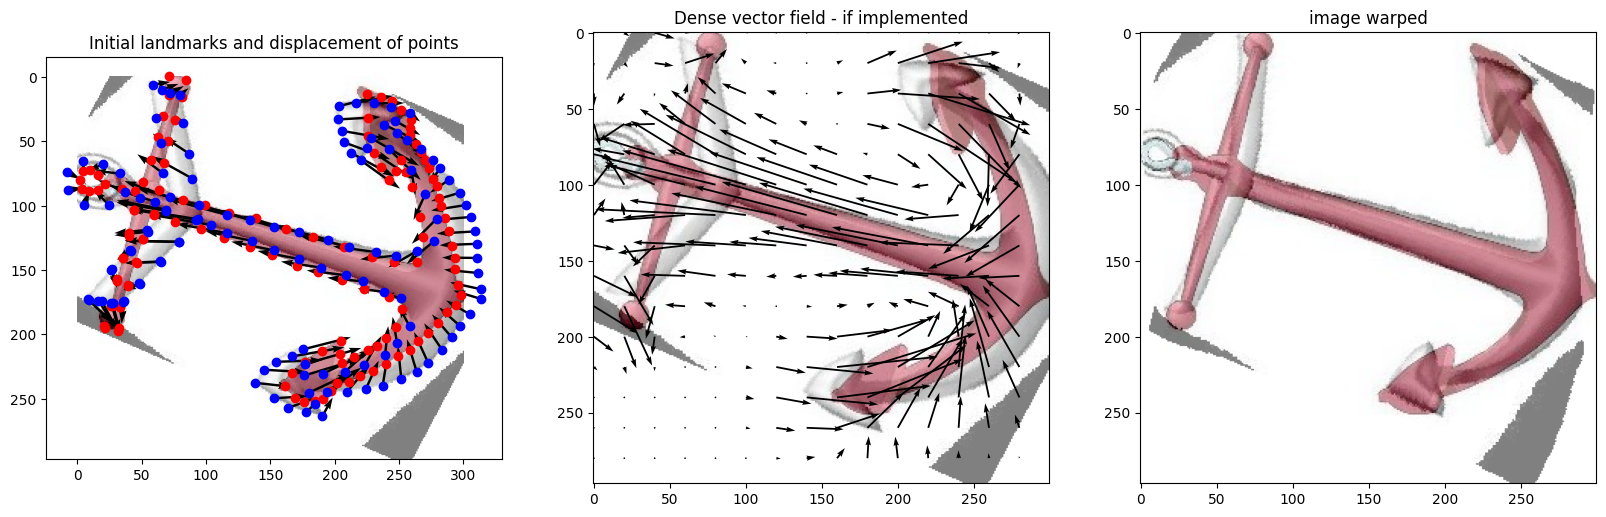

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
plt.imshow(Iref[:,column_util,:][row_util]);
plt.imshow(JregA[:,column_util,:][row_util],alpha=0.5)
plt.plot(PrefA[0,PtsInd],PrefA[1,PtsInd],'or')
plt.plot(PregA[0,PtsInd],PregA[1,PtsInd],'ob')
plt.quiver(PregA[0,PtsInd],PregA[1,PtsInd],v_landmarks[0],v_landmarks[1],scale=200,angles='xy')
plt.title('Initial landmarks and displacement of points')

row_util = row_util

plt.subplot(1,3,2)
plt.imshow(Iref[:,column_util,:][row_util])
plt.imshow(JregA[:,column_util,:][row_util],alpha=0.5)
######## HERE
# plt.quiver(grid_x,grid_y, v_grid[0], v_grid[1],angles='xy',scale=100) # line to uncomment if you want an overall displacement field, after coding it in the previous cell.
###############
plt.title('Dense vector field - if implemented')

plt.subplot(1,3,3)
plt.imshow(Iref[:,column_util,:][row_util])
plt.imshow(JregNL,alpha=0.5)
plt.title('image warped')

plt.show()

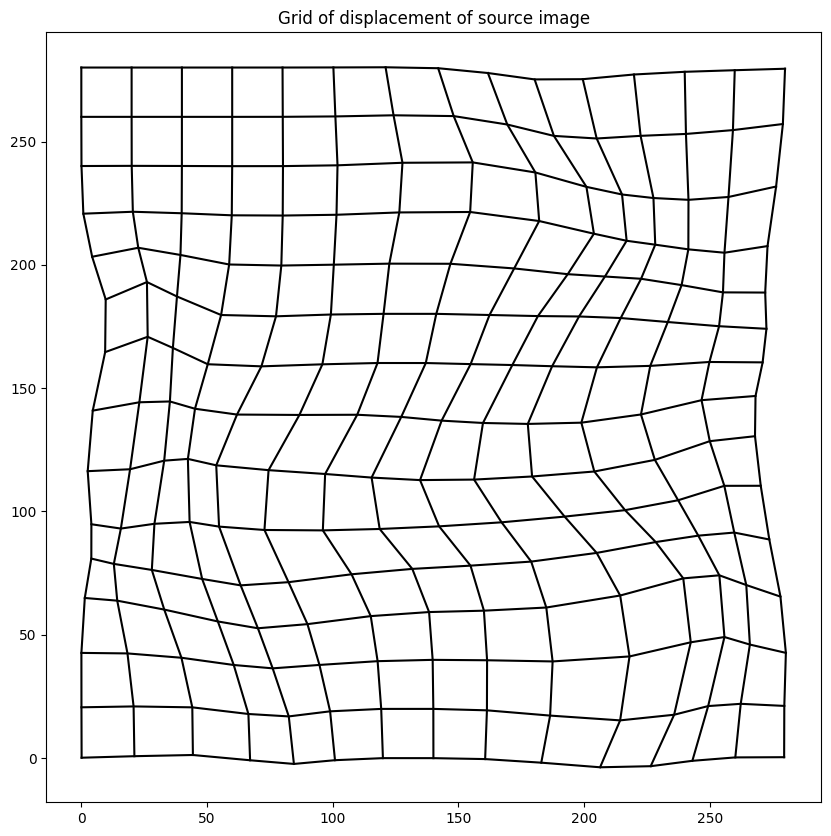

In [ ]:
###############
# !!!!! You can run this if you implemented the displacement field vectors vX and vY.

fig = plt.figure(figsize=(10,10))
axes = fig.add_subplot(111) 
# axes.imshow(Iref[:,cutil,:][rutil]) #plot the red anchor
# axes.imshow(JregNL,alpha=0.7) #plot the registered grey anchor
plot_grid_def(n_row,n_column,v_grid[0],v_grid[1],axes=axes)

axes.title.set_text('Grid of displacement of source image')


You obtain small deformations on the whole image by using a gaussian kernel with a big set of landmarks, and the associated grid. 

**Again, play with parameters and set of landmarks**. 

**Try to retrieve the different behaviors seen in class.**

**Q: How is this registration compared to the affine one ?  What can you say about the whole session, your understanding ?** 
